In [1]:
# download LitCovid dataset
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/LitCovid/biocreative/BC7-LitCovid-Train.csv
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/LitCovid/biocreative/BC7-LitCovid-Test.csv
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/LitCovid/biocreative/BC7-LitCovid-Test-GS.csv

--2023-05-23 09:08:27--  https://ftp.ncbi.nlm.nih.gov/pub/lu/LitCovid/biocreative/BC7-LitCovid-Train.csv
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 165.112.9.230, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44081235 (42M) [text/csv]
Saving to: ‘BC7-LitCovid-Train.csv’

BC7-LitCovid-Train. 100%[===================>]  42.04M  94.1MB/s    in 0.4s    

2023-05-23 09:08:28 (94.1 MB/s) - ‘BC7-LitCovid-Train.csv’ saved [44081235/44081235]

--2023-05-23 09:08:28--  https://ftp.ncbi.nlm.nih.gov/pub/lu/LitCovid/biocreative/BC7-LitCovid-Test.csv
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 165.112.9.230, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4669828 (4.5M) [text/csv]
Saving to: ‘BC7

In [2]:
!pip install shap lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import itertools
import gc
from collections import Counter
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import sklearn
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

import shap
from lime.lime_text import LimeTextExplainer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# utils
def save_to_pickle(path_to_file, itemlist):
    """ extenson -> .pkl """
    with open(path_to_file, 'wb') as fp:
        pickle.dump(itemlist, fp)
    print(f"saved file as pickle @ location: {path_to_file}")

def load_from_pickle(path_to_file):
    with open (path_to_file, 'rb') as fp:
        itemlist = pickle.load(fp)
    return itemlist 

In [15]:
class Biocreative_dataset:
    def __init__(self, path_to_train_file: str,
                 path_to_test_file: str,
                 feature_column: str='abstract'):
        
        self.path_to_train_file = path_to_train_file
        self.path_to_test_file = path_to_test_file
        self.feature_column = feature_column

        self.train_df, self.test_df, self.class_mappings = self.preprocess_data()
        self.labels = list(self.class_mappings.keys())

    def preprocess_data(self):
        """process LitCovid dataset & transform to multiclass setting"""
        train_df = pd.read_csv(self.path_to_train_file)
        test_df = pd.read_csv(self.path_to_test_file)
        
        # drop all columns except `abstract`, and `label`
        train_df.drop([label for label in train_df.columns.tolist() if label not in [self.feature_column, 'label']], axis=1, inplace=True)
        test_df.drop([label for label in test_df.columns.tolist() if label not in [self.feature_column, 'label']], axis=1, inplace=True)

        # get unique set of labels using `train_df`
        unique_label_set = train_df['label'].apply(lambda row: row.split(';')).tolist()
        labels = list(set(itertools.chain(*unique_label_set)))
        
        # select multiclass instances 
        train_df = train_df[train_df['label'].apply(lambda row: len(row.split(';')) == 1)]
        test_df = test_df[test_df['label'].apply(lambda row: len(row.split(';')) == 1)]

        class_mappings = dict(zip(labels, range(len(labels))))
        train_df['label'] = train_df['label'].map(class_mappings)
        test_df['label'] = test_df['label'].map(class_mappings)

        # drop NaN values
        train_df.dropna(inplace=True)
        test_df.dropna(inplace=True)

        if self.feature_column == 'keywords':
            train_df['keywords'] = df.apply(lambda row: " ".join(row['keywords'].split(';')), axis=1)
            test_df['keywords'] = df.apply(lambda row: " ".join(row['keywords'].split(';')), axis=1)
            train_df.dropna(inplace=True)
            test_df.dropna(inplace=True)

        return train_df, test_df, class_mappings

    def generate_features(self, 
                          encoding_type='tfidf',
                          stop_words='english'):
        """apply either BOW or TfidF vectorization to input-data"""
        if encoding_type == "tfidf":
            vectorizer = TfidfVectorizer(lowercase=True, 
                                        stop_words=stop_words,
                                        max_features=10000,
                                        norm='l2')
            X_train = vectorizer.fit_transform(self.train_df[self.feature_column])
            X_test = vectorizer.transform(self.test_df[self.feature_column])
        elif encoding_type == "bow":
            vectorizer = CountVectorizer(lowercase=True,
                                        stop_words=stop_words,
                                        max_features=10000)
            X_train = vectorizer.fit_transform(self.train_df[self.feature_column])
            X_test = vectorizer.transform(self.test_df[self.feature_column])
        return X_train, X_test, vectorizer

In [16]:
biocreative_dataset = Biocreative_dataset("/content/BC7-LitCovid-Train.csv", "/content/BC7-LitCovid-Test-GS.csv", feature_column='abstract')
# generate feature encodings
X_train, X_test, vectorizer = biocreative_dataset.generate_features(encoding_type="tfidf", # tfidf or bow
                                                                    stop_words="english")

y_train, y_test = biocreative_dataset.train_df['label'].to_numpy(), biocreative_dataset.test_df['label'].to_numpy() # get ground-truth labels

In [17]:
def sample_from_dataset(X: np.ndarray,
                        y: np.ndarray,
                        sample_size: int):
    
    label_counts = np.bincount(y)
    label_distribution = label_counts / len(y)
    new_X = []
    new_y = []
    for label in range(len(label_counts)):
        label_size = int(new_size * label_distribution[label])
        label_indices = np.where(y == label)[0]
        selected_indices = np.random.choice(label_indices, size=label_size, replace=False)
        new_X.extend(X[selected_indices])
        new_y.extend(y[selected_indices])

    new_X = np.array(new_X)
    new_y = np.array(new_y)
    indices = np.random.permutation(len(new_X))
    new_X = new_X[indices]
    new_y = new_y[indices]
    return new_X, new_y

# sample_X_train, sample_y_train = sample_from_dataset(X_train.toarray(), y_train, 500)aa

def find_best_hyperparam(X_train, y_train):
    n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
    max_features = ['auto', 'sqrt']
    bootstrap = [True, False]
    param_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'bootstrap': bootstrap
    }
    rf_model = RandomForestClassifier()
    rf_grid = GridSearchCV(estimator=rf_model,
                        param_grid=param_grid,
                        cv=10,
                        verbose=2,
                        n_jobs=4)
    rf_grid.fit(X_train, y_train)
    return rf_grid.best_params_

In [18]:
# Train RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Evaluation
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=biocreative_dataset.labels))

0.8312375909993381
                      precision    recall  f1-score   support

          Prevention       0.79      0.98      0.88       746
        Transmission       0.00      0.00      0.00        11
         Case Report       0.93      0.77      0.85       195
           Treatment       0.85      0.65      0.73       251
           Diagnosis       0.87      0.77      0.82       217
           Mechanism       0.98      0.56      0.71        77
Epidemic Forecasting       1.00      0.07      0.13        14

            accuracy                           0.83      1511
           macro avg       0.78      0.54      0.59      1511
        weighted avg       0.84      0.83      0.82      1511



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [20]:
# Save model 
filename = "100_RandomForestClassifier.sav"
pickle.dump(model, open(filename, 'wb'))
model_ = pickle.load(open(filename, 'rb'))

In [21]:
# confusion plot 
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=labels,
    cmap=plt.cm.Blues,
    xticks_rotation='vertical'
)
disp.ax_.set_title("Confusion Plot `abstract`")

plt.show()

NameError: ignored

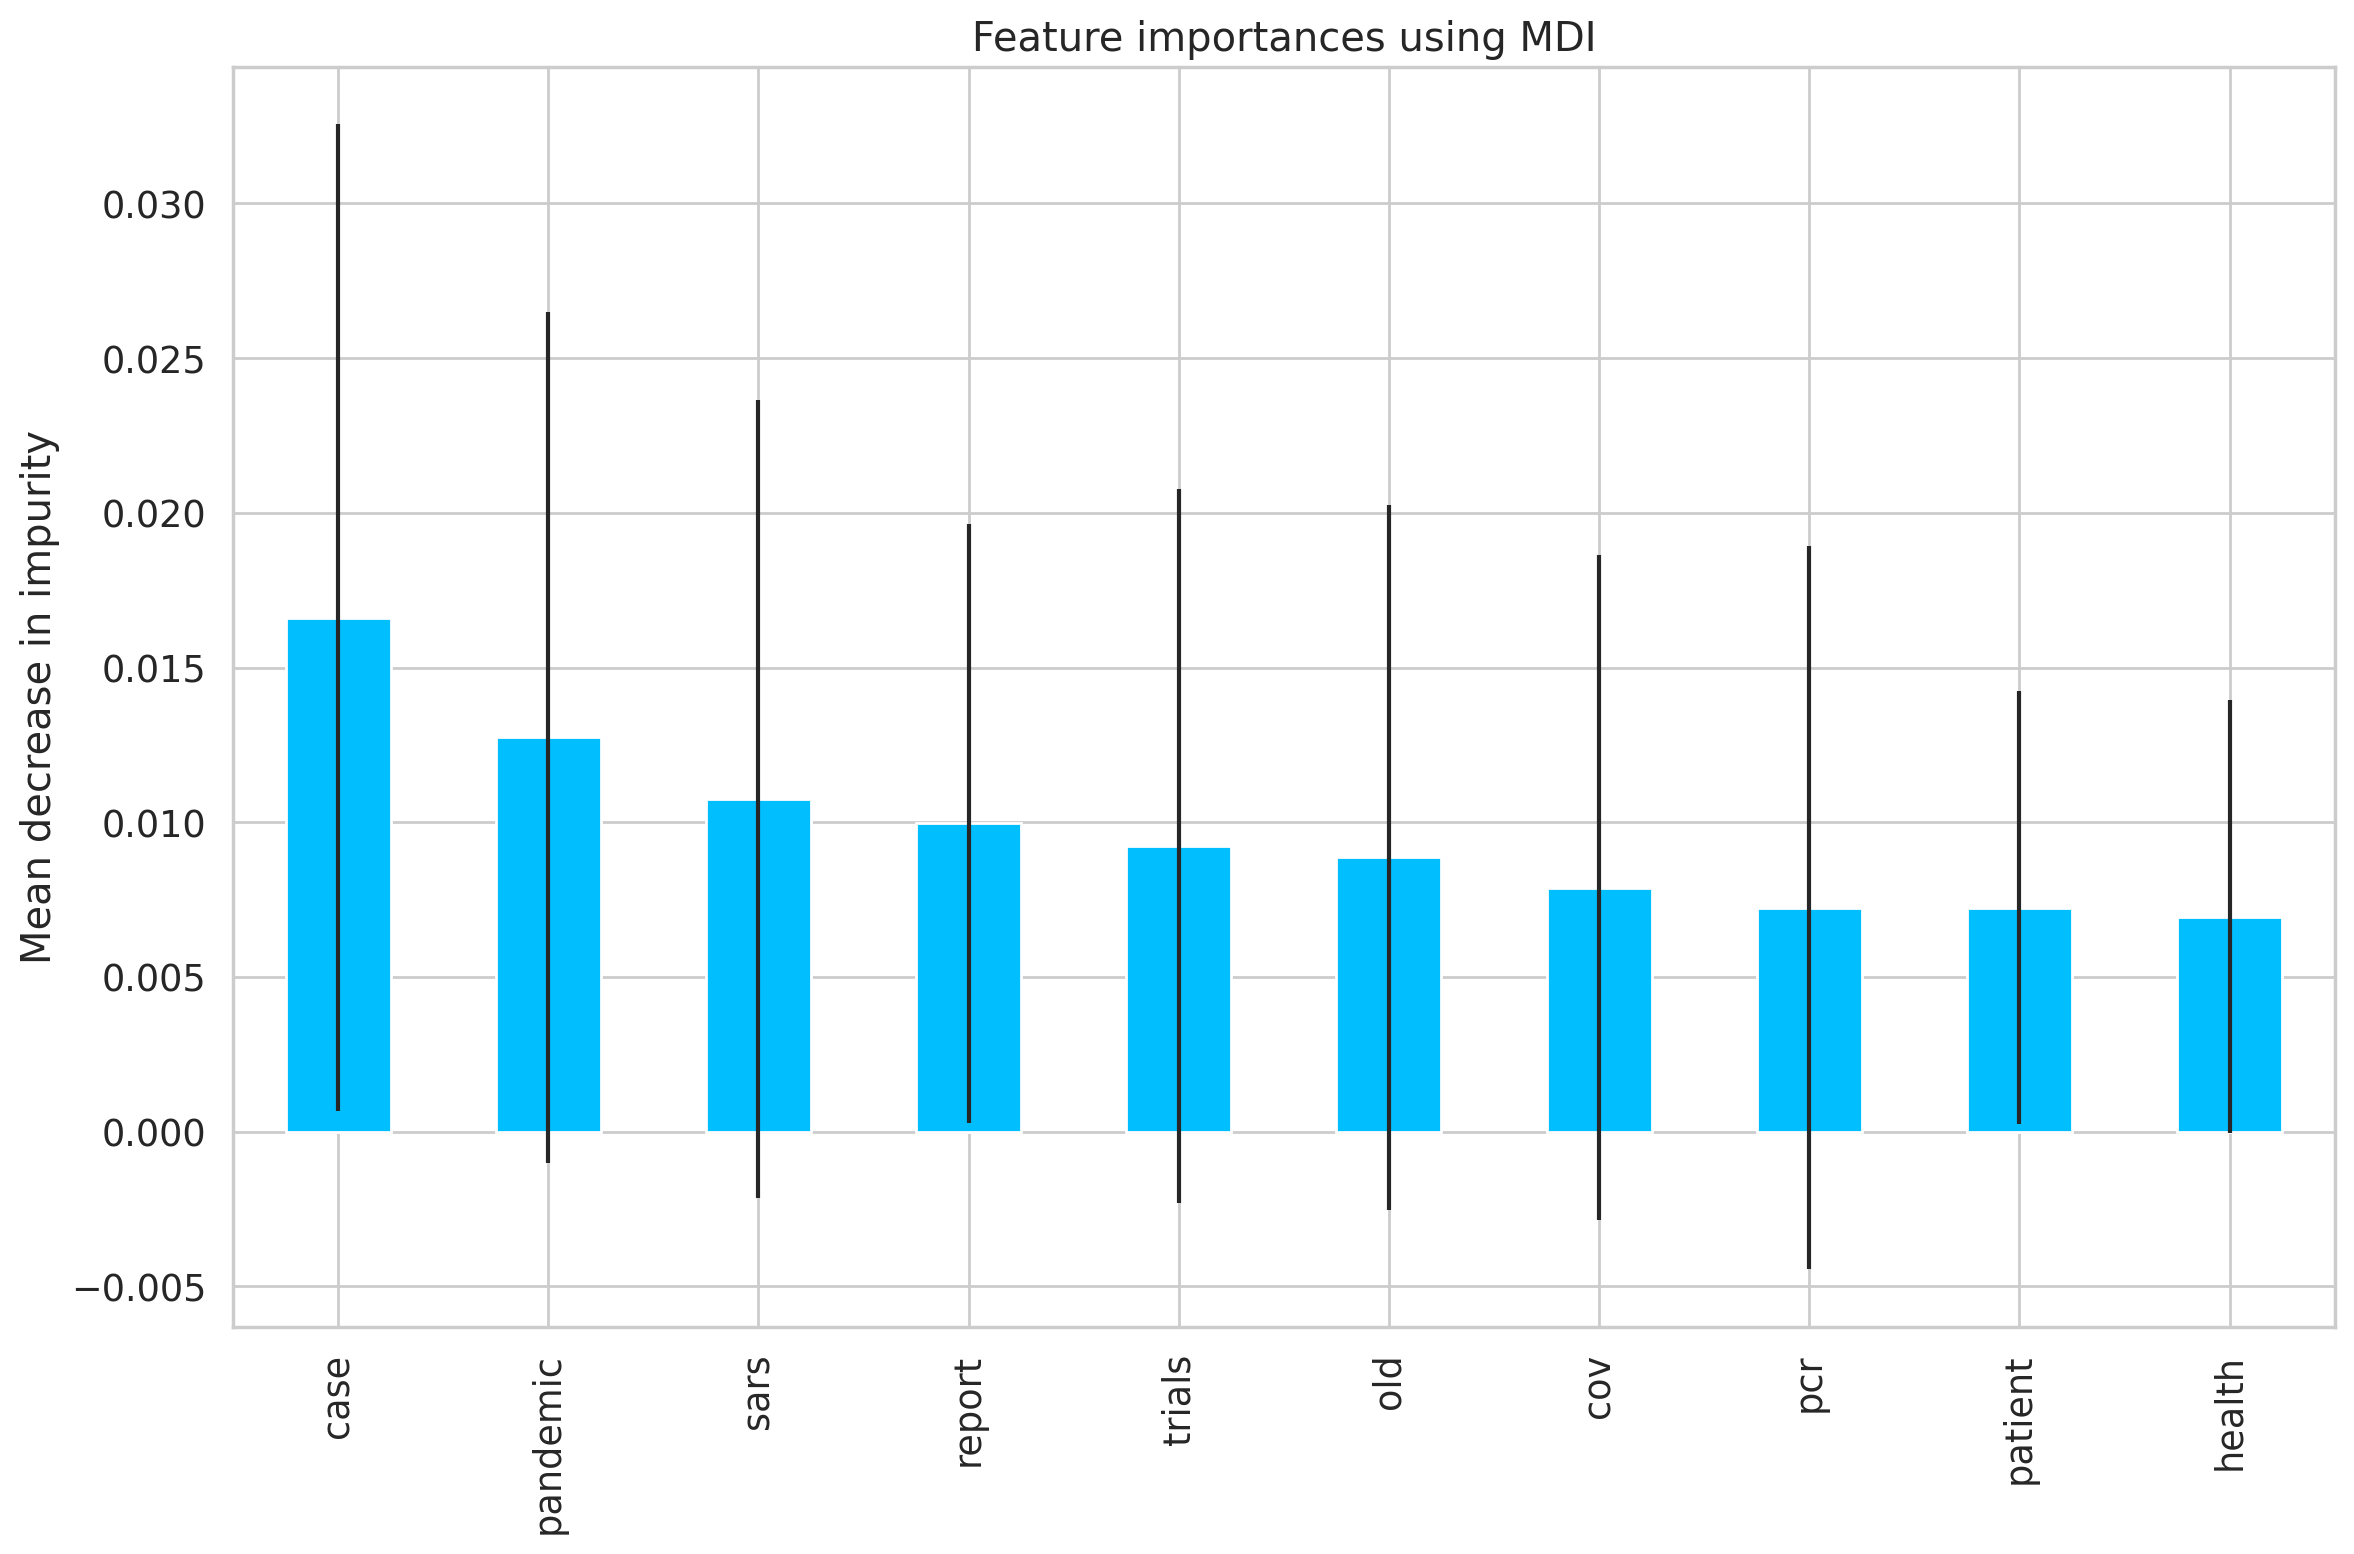

In [22]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

top_indices = importances.argsort()[-10:][::-1]
top_features = vectorizer.get_feature_names_out()[top_indices]
top_importances = importances[top_indices]
top_stds = std[top_indices]

forest_importances = pd.Series(top_importances, index=top_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=top_stds, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [23]:
class shap_global_and_local_interpretability:
    def __init__(self, model: sklearn.ensemble._forest.RandomForestClassifier,
                       vectorizer: sklearn.feature_extraction.text.TfidfVectorizer,
                       X_train: np.ndarray,
                       X_test: np.ndarray,
                       labels: list):
        super(shap_global_and_local_interpretability, self).__init__()

        gc.collect()
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.labels = labels
        self.class_mappings = dict(zip(labels, range(len(labels))))

        self.explainer = shap.TreeExplainer(model)
        self.shap_values = self.explainer.shap_values(X_test, approximate=True)

    def overall_summary_plot(self):

        fig = shap.summary_plot(self.shap_values, self.X_test, 
                                plot_type="bar", max_display=10,
                                feature_names=self.vectorizer.get_feature_names_out().tolist(),
                                class_names=self.labels)
        gc.collect()
        return fig

    def classwise_summary_plot(self, classname: str, max_display=10):

        assert [classname] not in self.labels, "Provide appropriate classname; \
        should be one of the following: {}".format(self.labels)
        
        class_idx = self.class_mappings[classname]
        fig = shap.summary_plot(self.shap_values[class_idx], 
                                self.X_test, max_display=max_display, class_names=self.labels,
                                feature_names=self.vectorizer.get_feature_names_out().tolist())
        
        gc.collect()
        return fig

    def force_plot(self, classname: str, row_id: int, show: bool=True,
                   matplotlib: bool=False):

        assert [classname] not in self.labels, "Provide appropriate classname; \
        should be one of the following: {}".format(self.labels)

        shap.initjs()

        class_idx = self.class_mappings[classname]
        fig = shap.force_plot(self.explainer.expected_value[class_idx],
                              self.shap_values[class_idx][row_id],
                              self.X_test[row_id],
                              feature_names=self.vectorizer.get_feature_names_out().tolist(),
                              matplotlib=matplotlib,
                              show=show)
        
        gc.collect()
        return fig

    def waterfall_plot(self, classname: str, row_id: int):

        assert [classname] not in self.labels, "Provide appropriate classname; \
        should be one of the following: {}".format(self.labels)

        class_idx = self.class_mappings[classname]
        fig = shap.waterfall_plot(shap.Explanation(values=self.shap_values[class_idx][row_id],
                                             base_values=self.explainer.expected_value[class_idx],
                                             data=self.X_test[row_id],
                                             feature_names=self.vectorizer.get_feature_names_out().tolist()))
        
        gc.collect()
        return fig

In [25]:
sgli = shap_global_and_local_interpretability(model_,
                                              vectorizer,
                                              X_train.toarray(),
                                              X_test.toarray(),
                                              biocreative_dataset.labels)

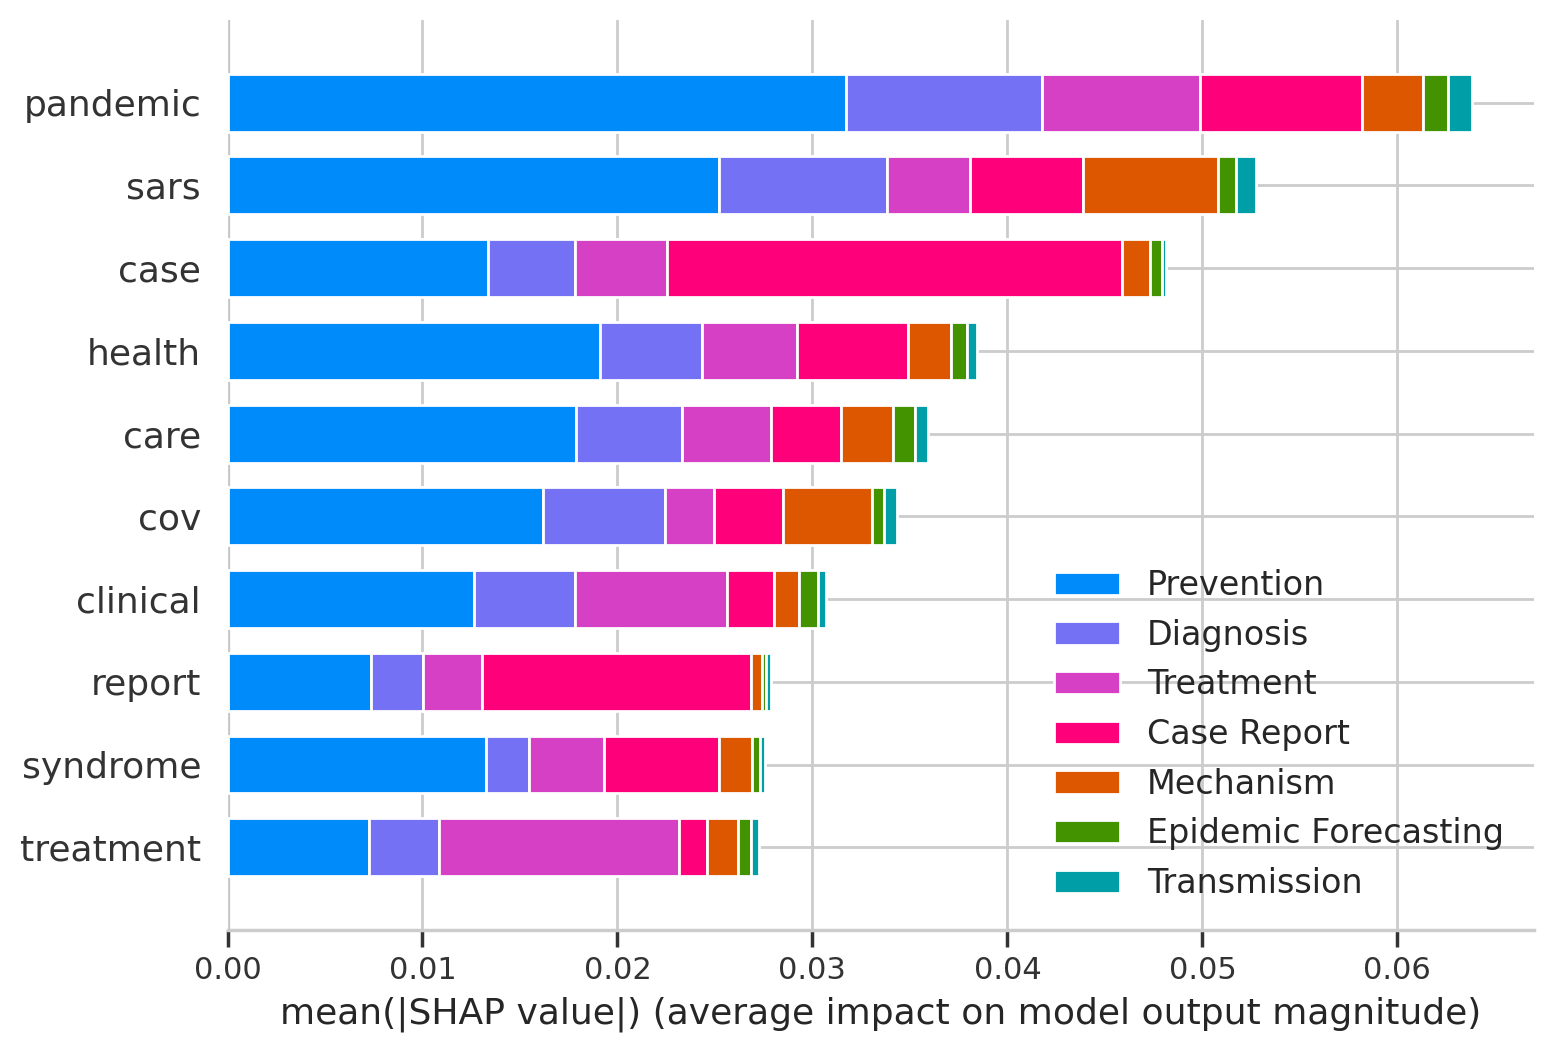

In [26]:
sgli.overall_summary_plot()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


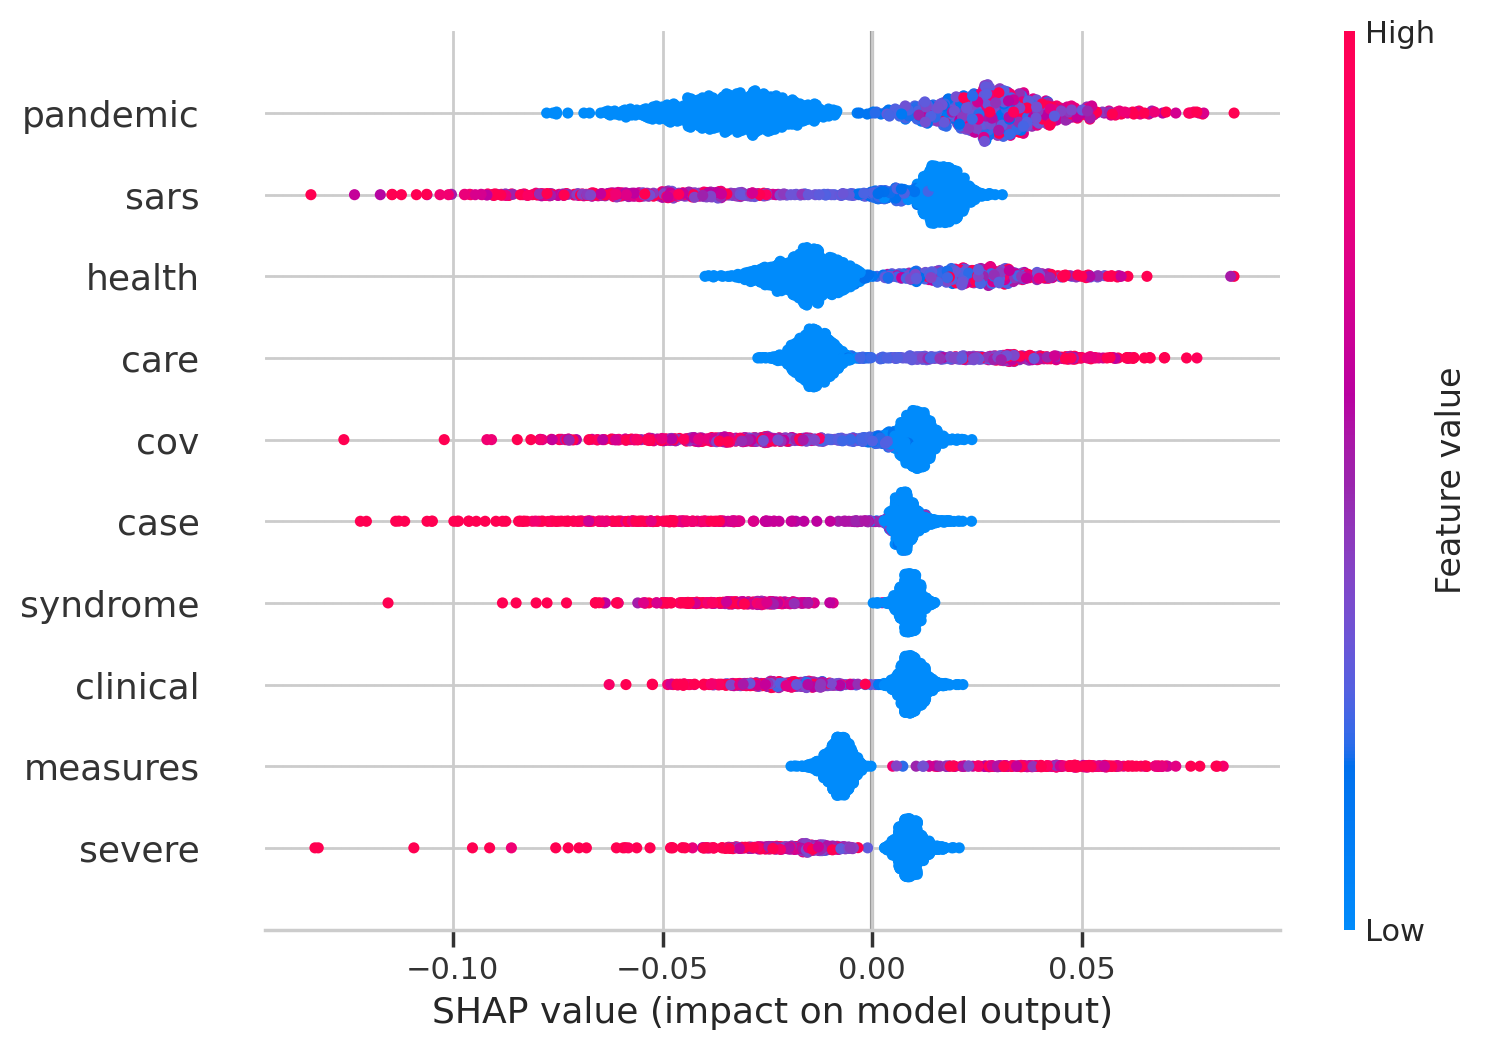

In [27]:
sgli.classwise_summary_plot(classname='Prevention')

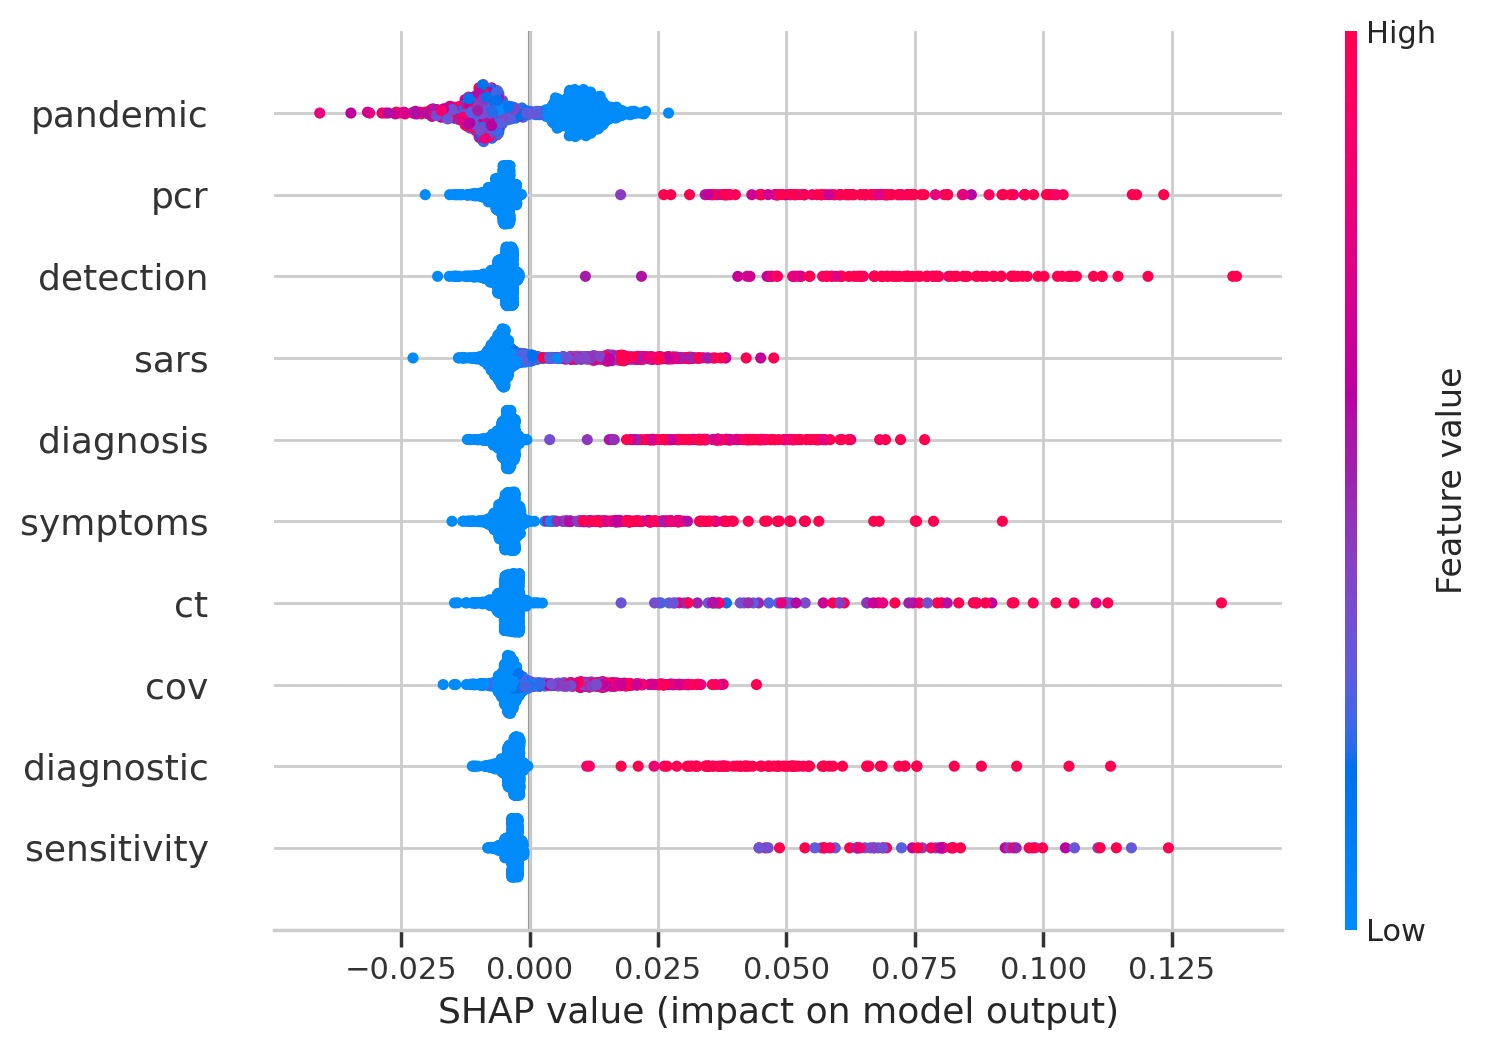

In [28]:
sgli.classwise_summary_plot(classname='Diagnosis')

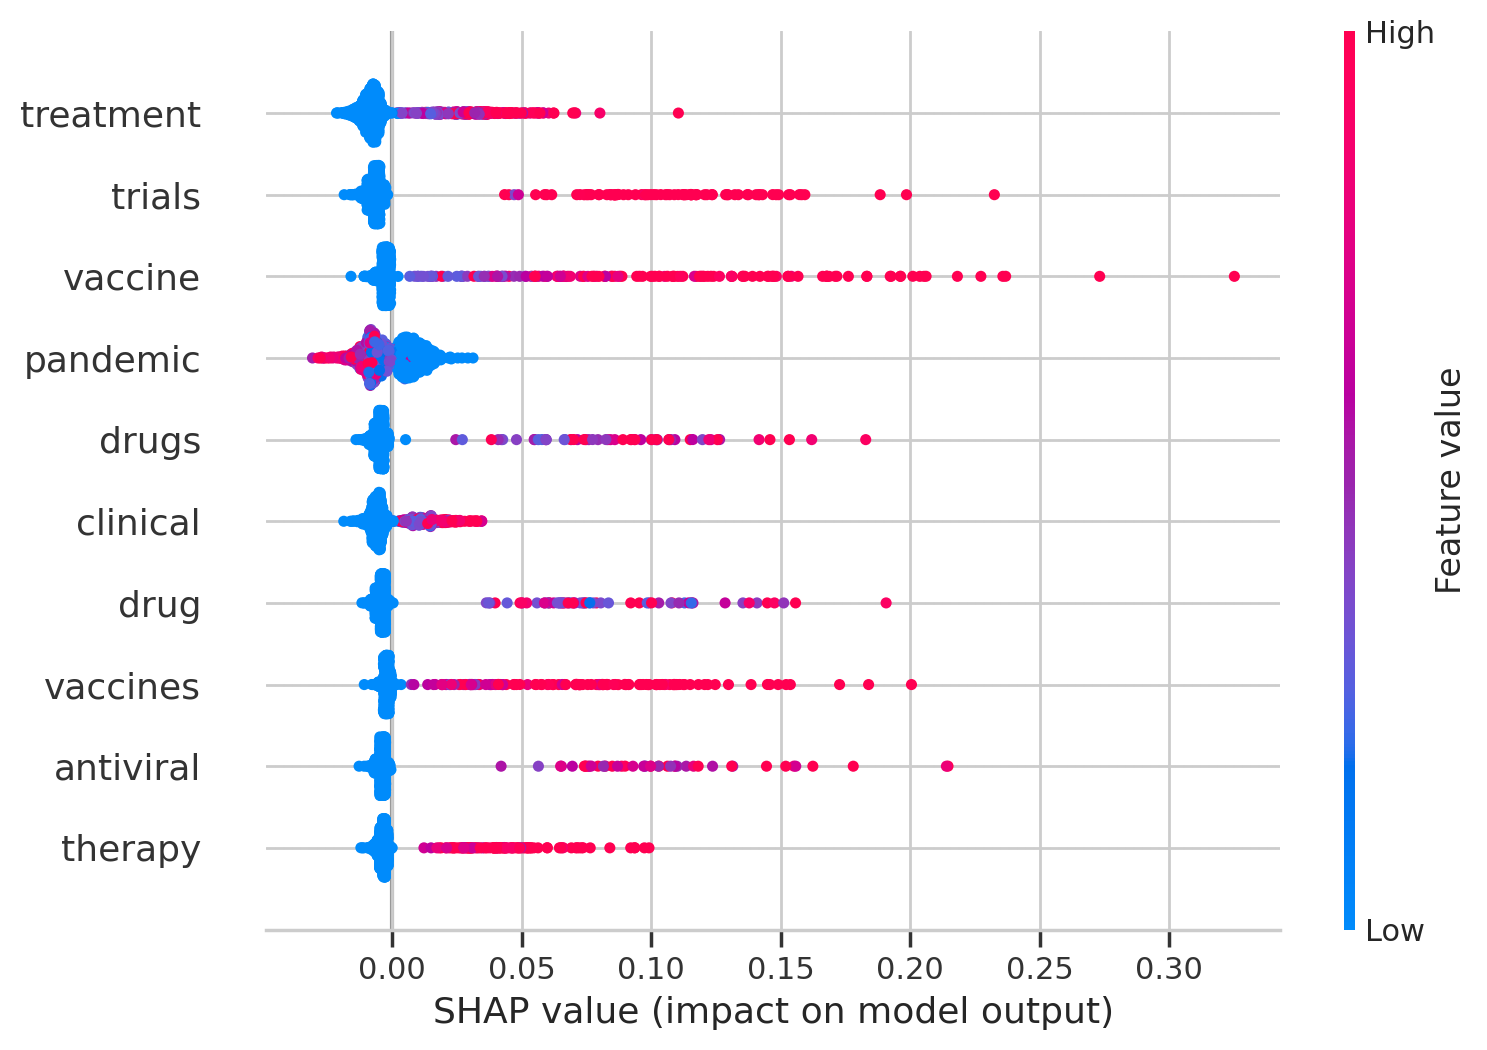

In [29]:
sgli.classwise_summary_plot(classname='Treatment')

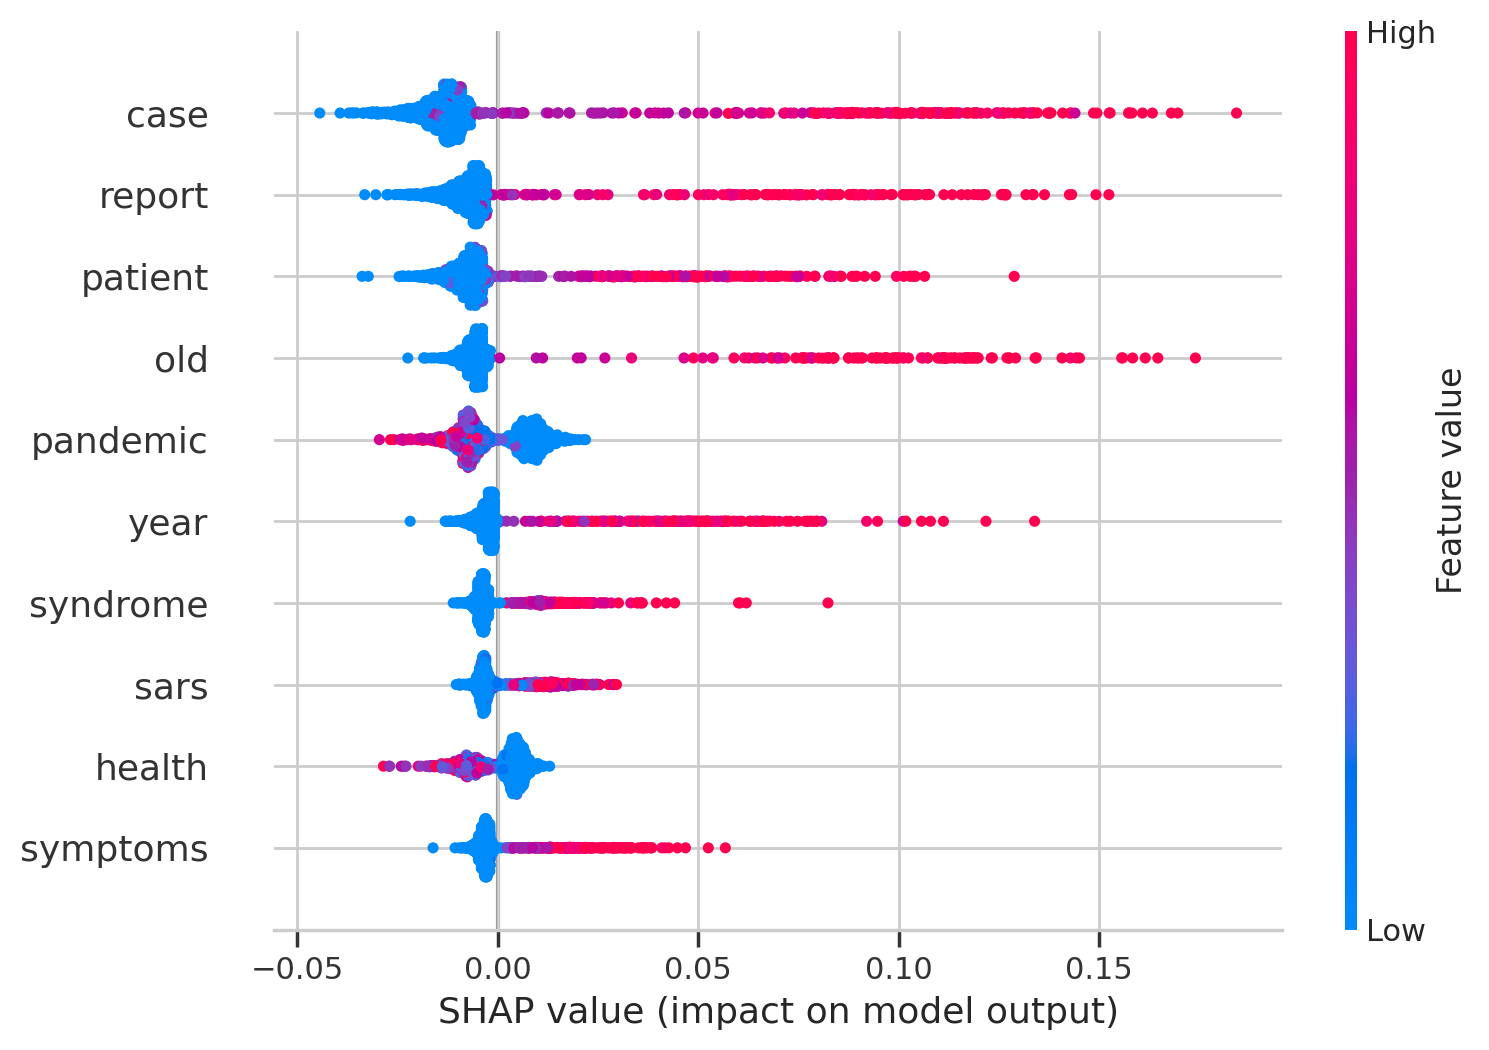

In [30]:
sgli.classwise_summary_plot(classname='Case Report')

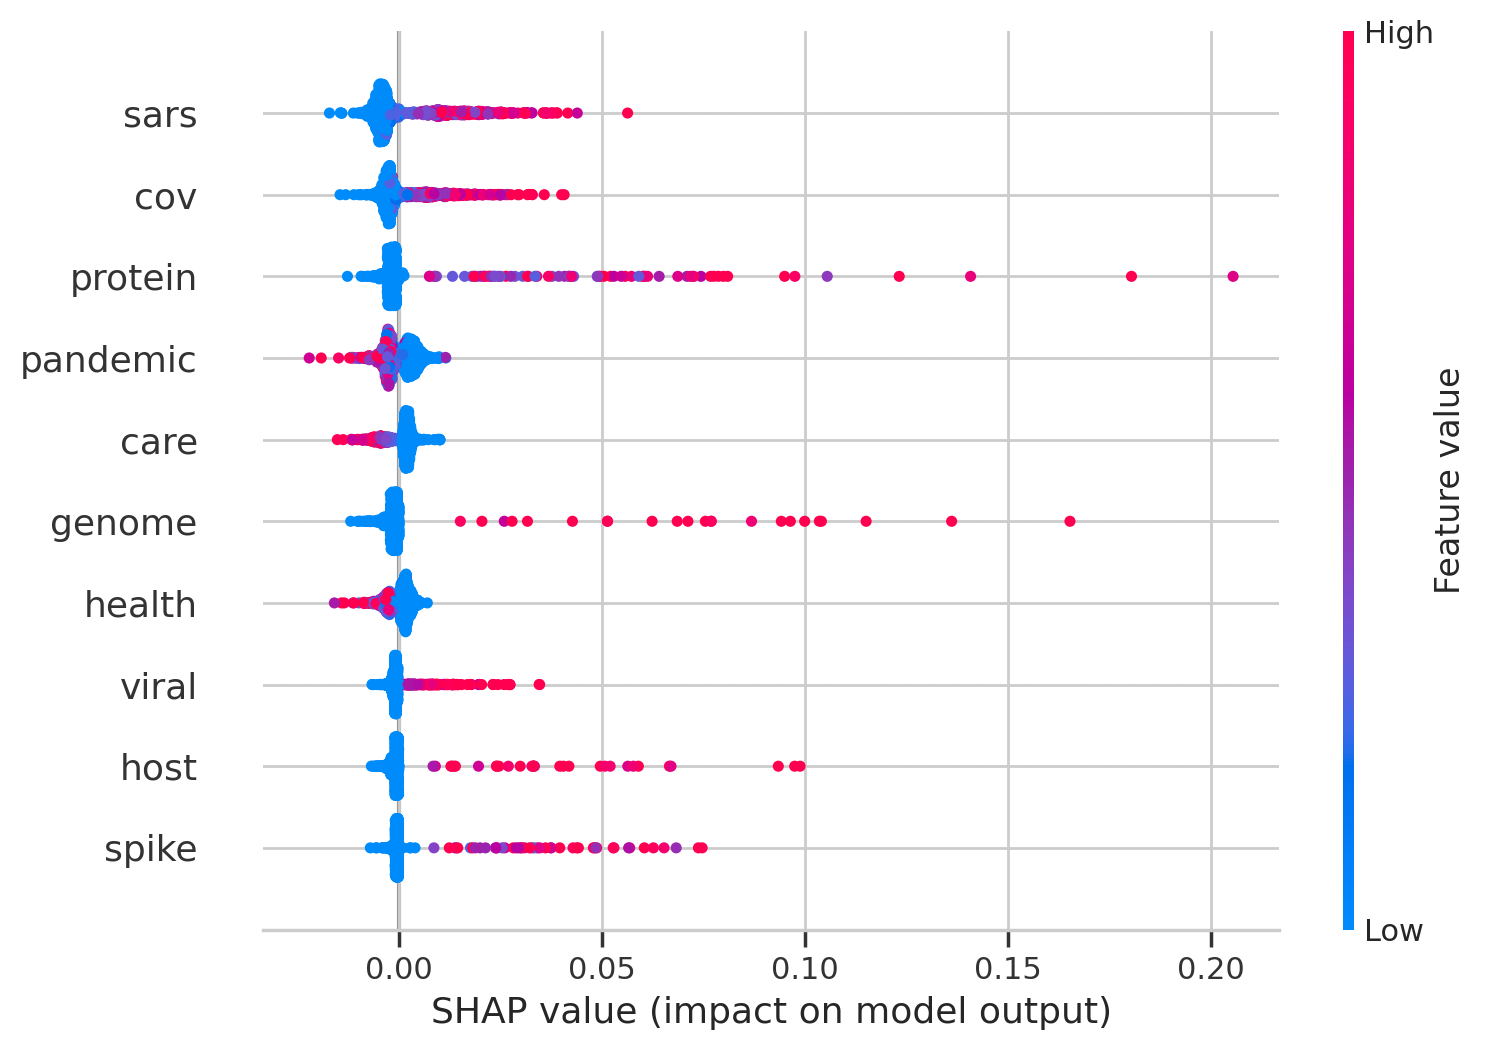

In [31]:
sgli.classwise_summary_plot(classname='Mechanism')

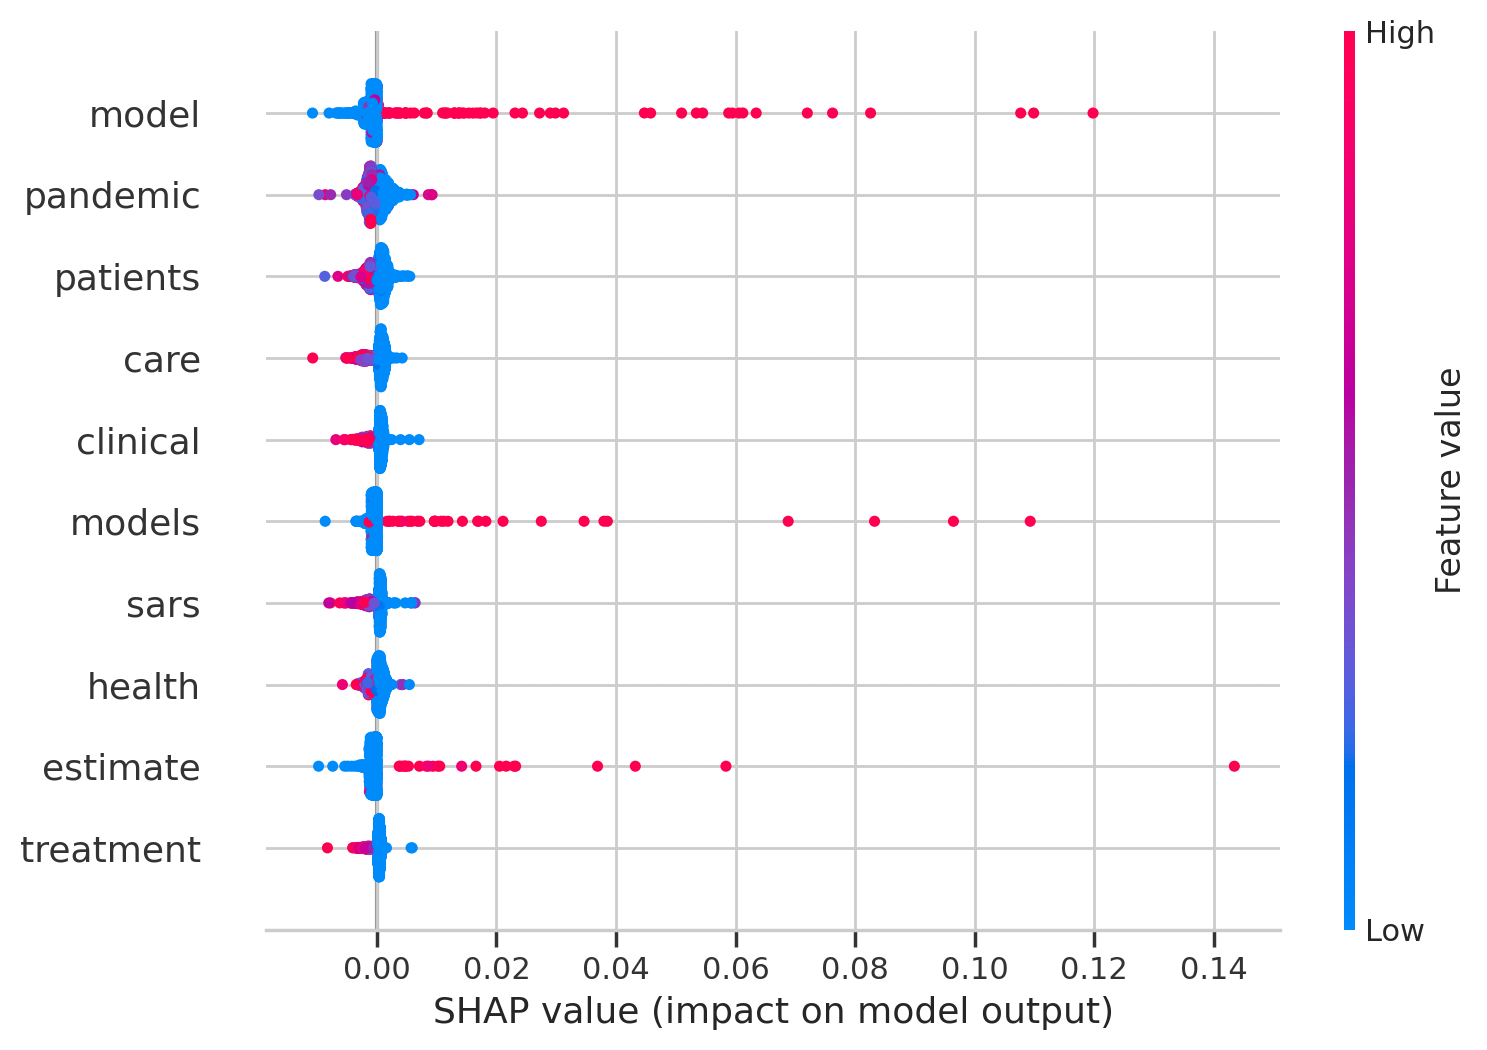

In [32]:
sgli.classwise_summary_plot(classname='Epidemic Forecasting')

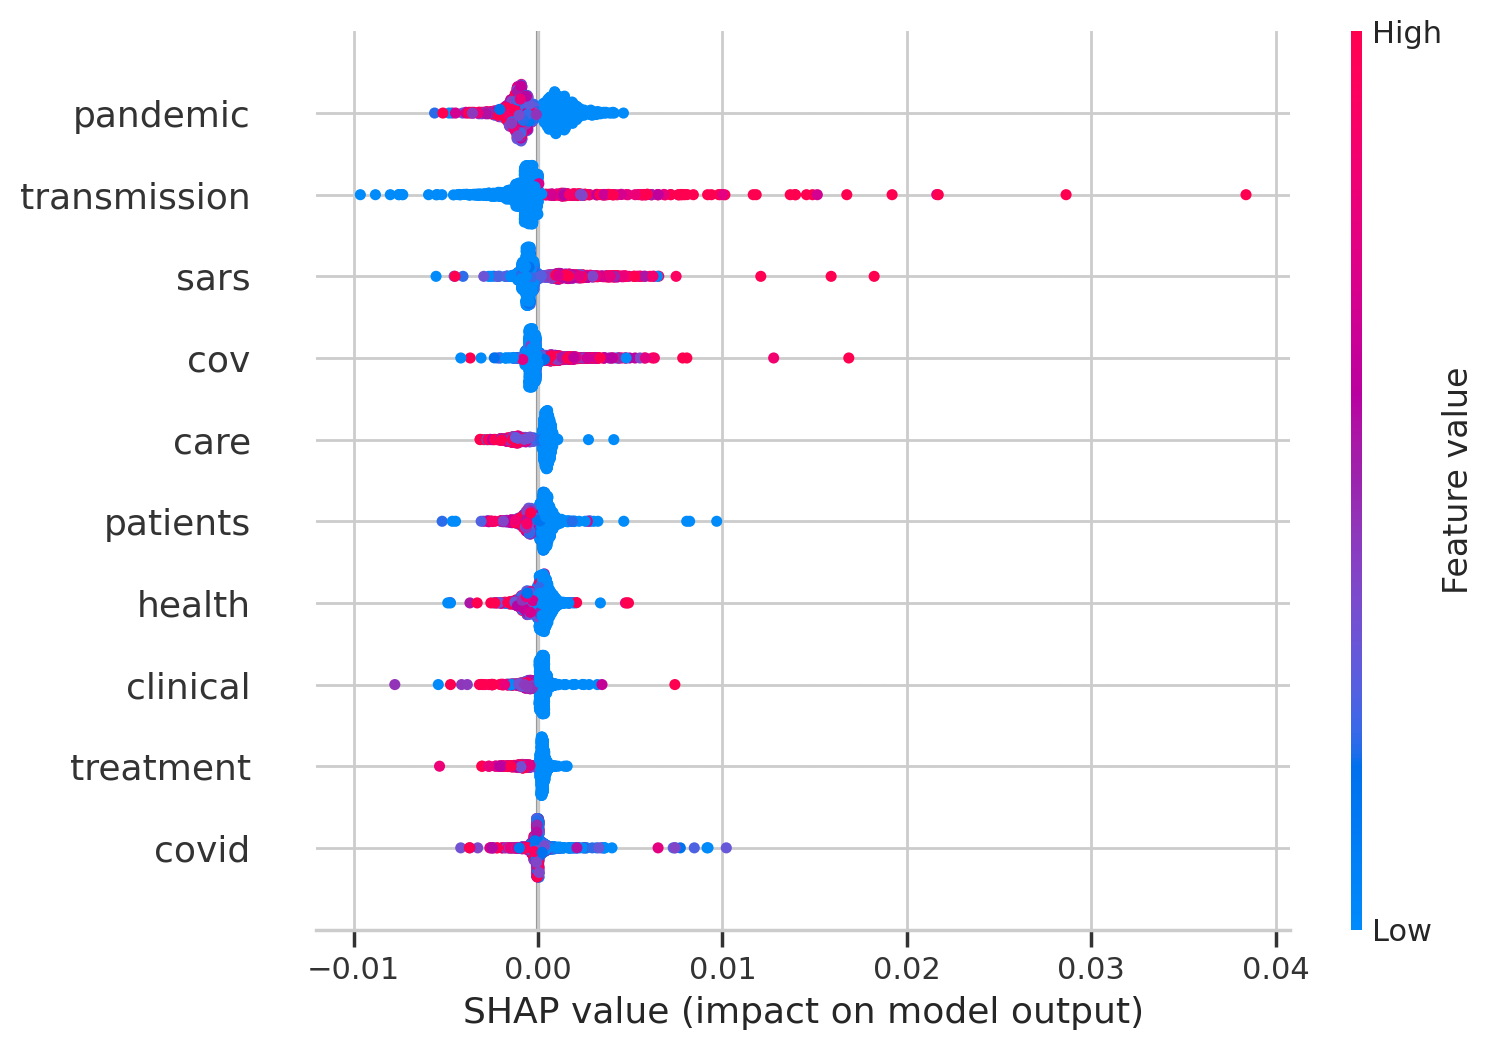

In [33]:
sgli.classwise_summary_plot(classname='Transmission')

In [35]:
biocreative_dataset.class_mappings

{'Prevention': 0,
 'Transmission': 1,
 'Case Report': 2,
 'Treatment': 3,
 'Diagnosis': 4,
 'Mechanism': 5,
 'Epidemic Forecasting': 6}

In [39]:
((y_test == biocreative_dataset.class_mappings["Prevention"]) & (y_pred != y_test)).nonzero()[0].tolist()

[88, 129, 216, 283, 456, 702, 759, 919, 953, 1091, 1141, 1388, 1469, 1487]

In [40]:
(y_test == biocreative_dataset.class_mappings["Prevention"]).nonzero()[0][:10].tolist()

[2, 3, 4, 5, 7, 8, 9, 11, 12, 13]

In [41]:
sgli.force_plot("Treatment", 2)

In [42]:
sgli.force_plot("Prevention", 88)

In [43]:
sgli.force_plot("Treatment", 88)

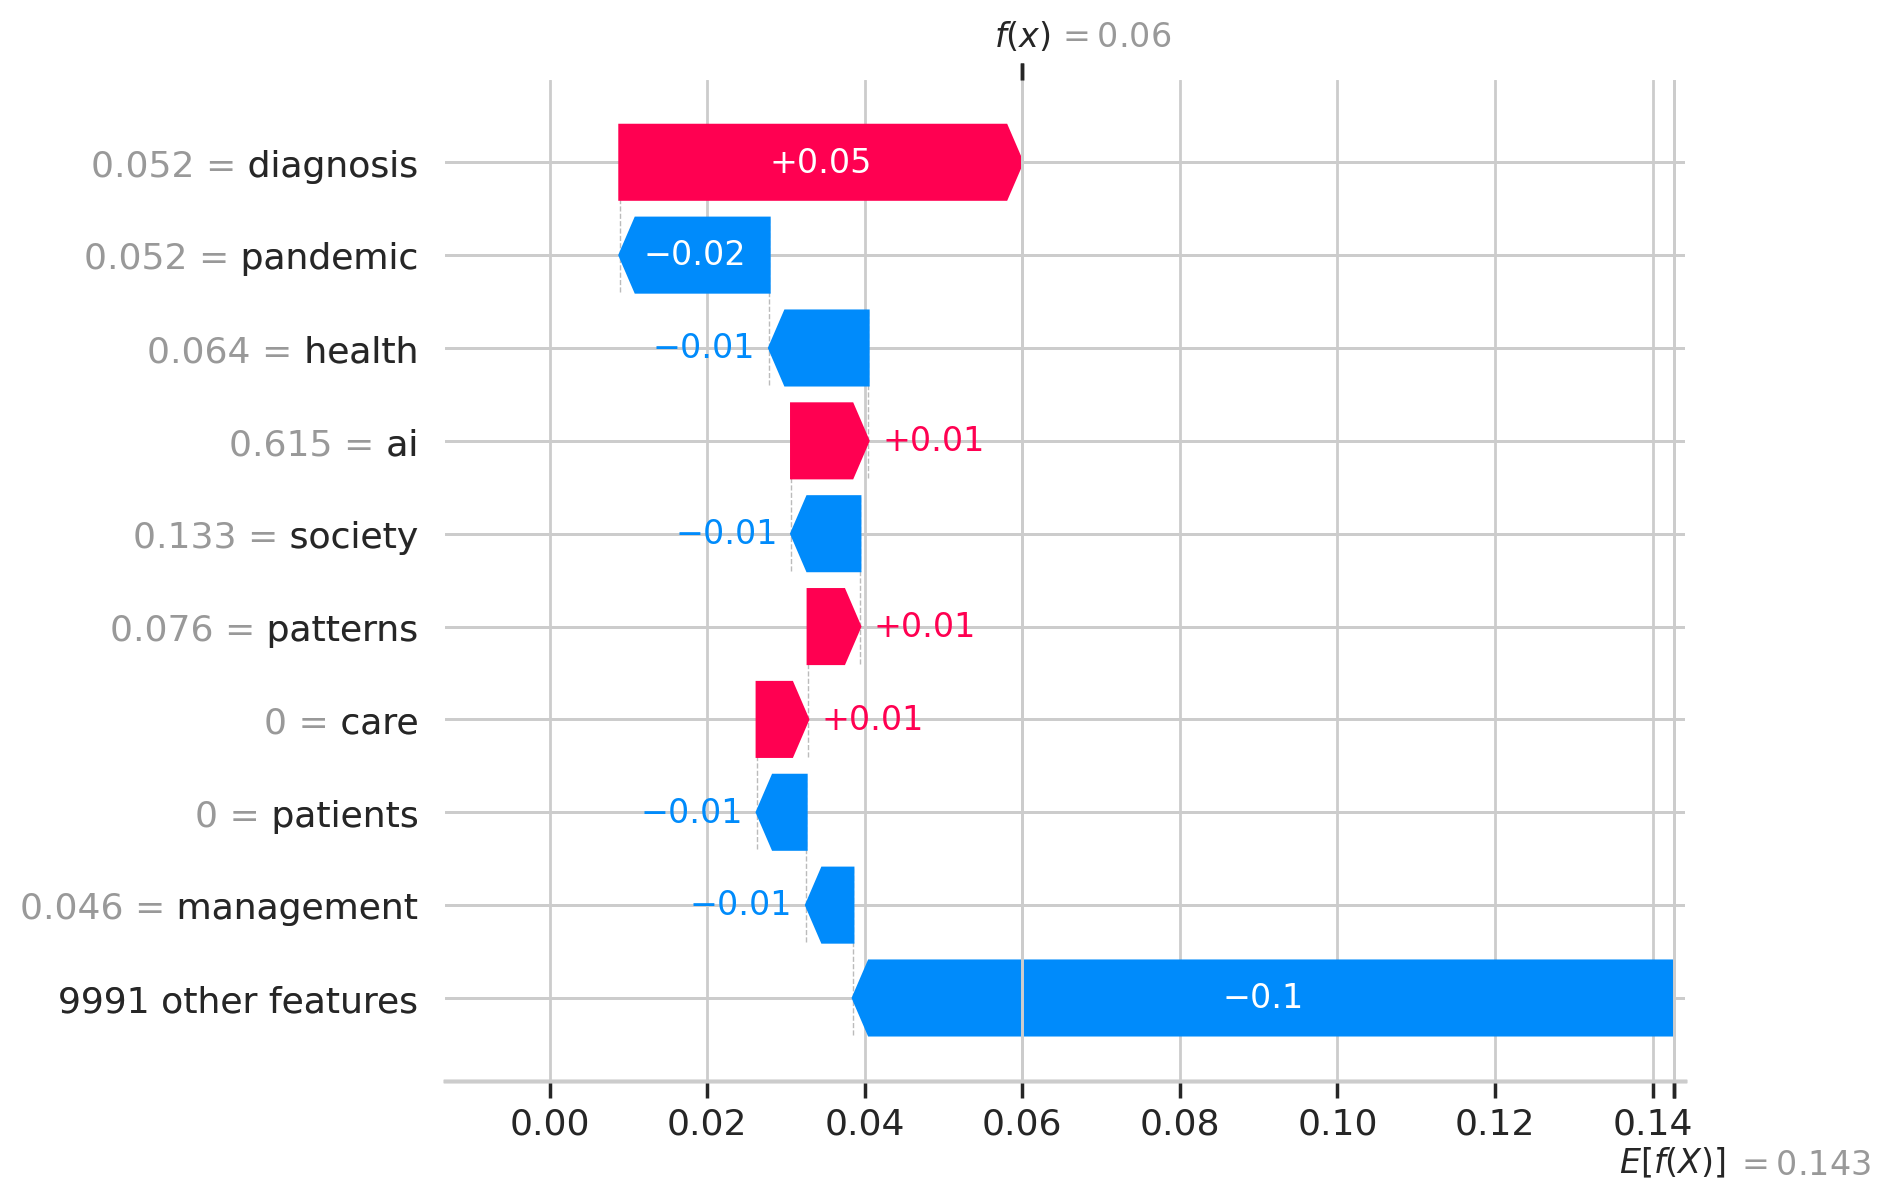

In [44]:
sgli.waterfall_plot("Diagnosis", 179)

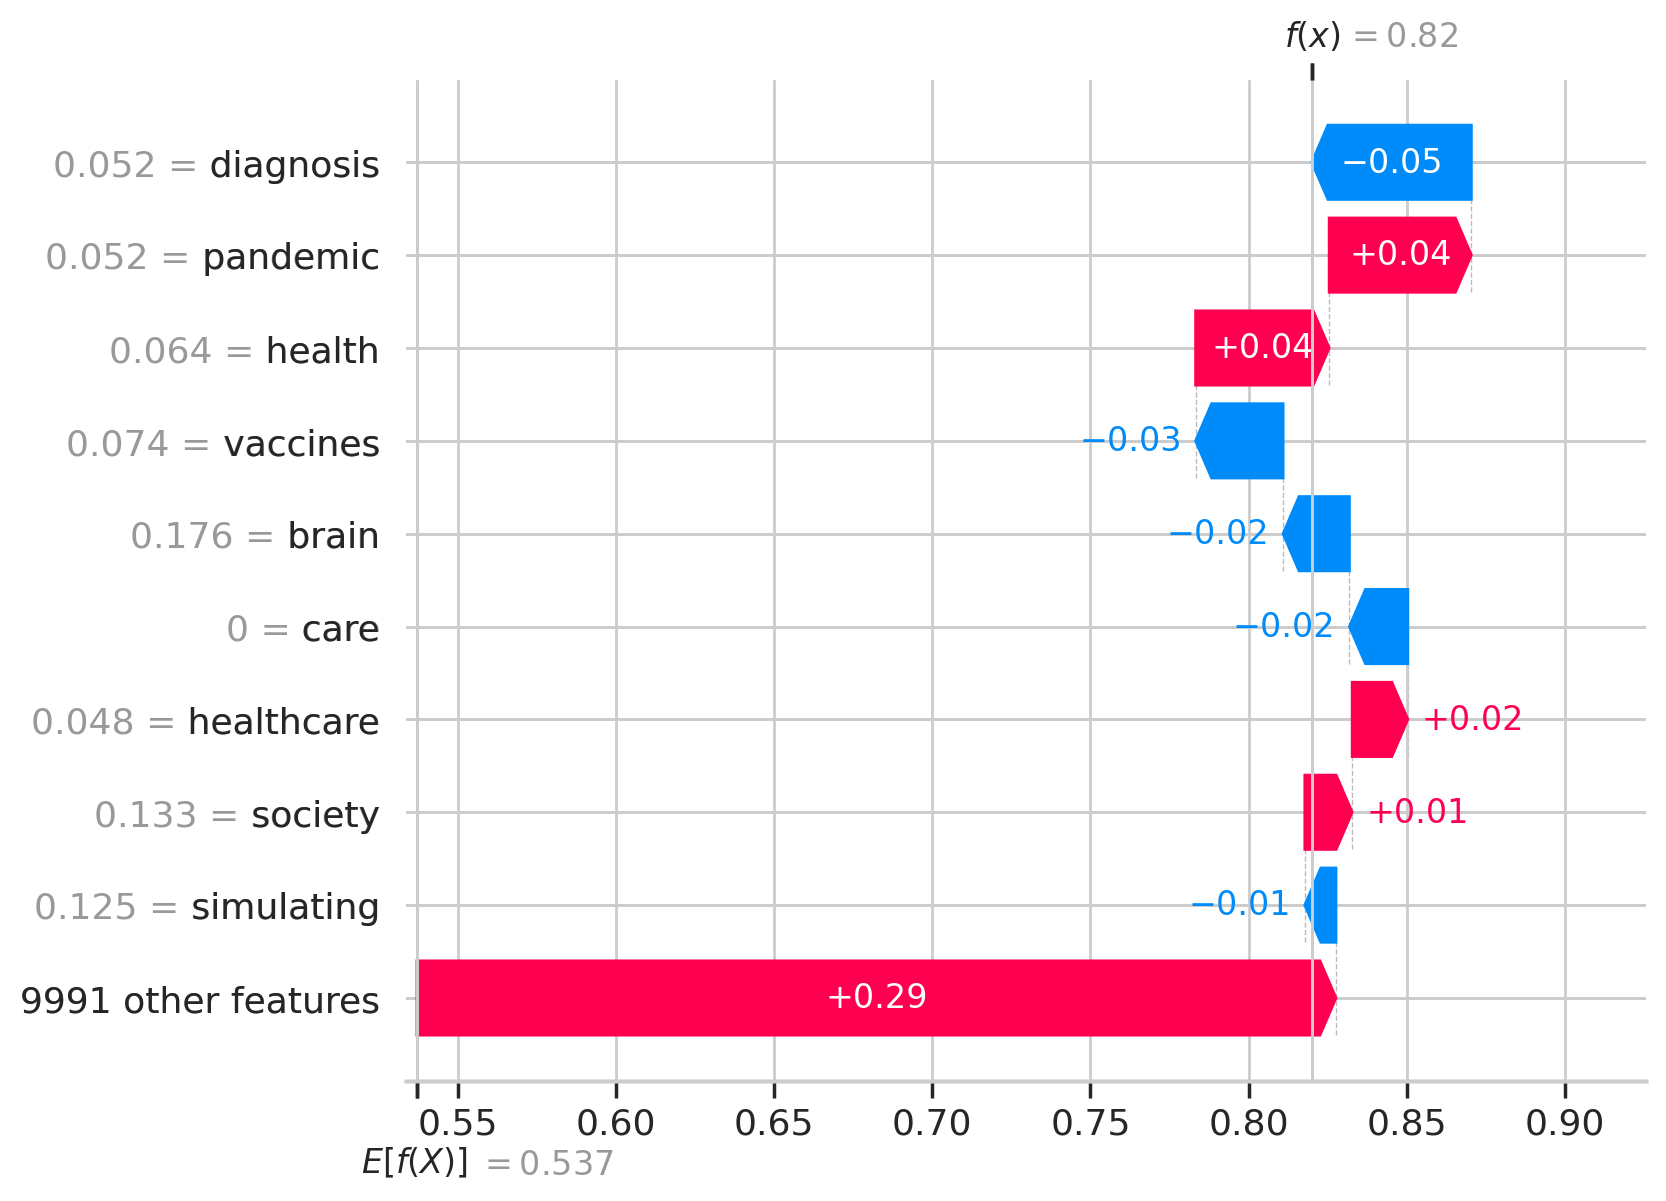

In [45]:
sgli.waterfall_plot("Prevention", 179)

In [46]:
class LIME_interpretability:
    def __init__(self, model: sklearn.ensemble._forest.RandomForestClassifier,
                       vectorizer: sklearn.feature_extraction.text.TfidfVectorizer,
                       train_data: pd.DataFrame,
                       test_data: pd.DataFrame,
                       labels: list,
                       text_column: str="abstract",): 
        super(LIME_interpretability, self).__init__()

        gc.collect()
        self.model = model
        self.vectorizer = vectorizer
        self.train_data = train_data
        self.test_data = test_data
        self.labels = labels
        self.text_column = text_column

        self.class_mappings = dict(zip(labels, range(len(labels))))
        self.pipeline = make_pipeline(vectorizer, model)

        self.explainer = LimeTextExplainer(class_names=labels)
    
    def generate_top_k_class_labels(self, row_id: int, top_k: int=2, 
                                          num_features: int=5):

        exp = self.explainer.explain_instance(self.test_data.iloc[row_id][self.text_column], 
                                         self.pipeline.predict_proba, 
                                         num_features=num_features, 
                                         top_labels=top_k)
        # print(exp.available_labels())

        gc.collect()
        return exp.show_in_notebook(text=False)  

    def  generate_class_labels_w_text(self, row_id: int, classname: str,
                                      num_features: int=5):
        
        assert [classname] not in self.labels, "Provide appropriate classname; \
        should be one of the following: {}".format(self.labels)

        class_idx = self.class_mappings[classname]
        exp = self.explainer.explain_instance(self.test_data.iloc[row_id][self.text_column], 
                                         self.pipeline.predict_proba, 
                                         num_features=num_features,
                                         labels=list(class_mappings.values()))
        
        gc.collect()
        return exp.show_in_notebook(text=self.test_data.iloc[row_id][self.text_column], 
                                    labels=(class_idx,))

In [48]:
li = LIME_interpretability(model_,
                           vectorizer,
                           biocreative_dataset.train_df,
                           biocreative_dataset.test_df,
                           biocreative_dataset.labels,
                           "abstract")

In [50]:
biocreative_dataset.class_mappings

{'Prevention': 0,
 'Transmission': 1,
 'Case Report': 2,
 'Treatment': 3,
 'Diagnosis': 4,
 'Mechanism': 5,
 'Epidemic Forecasting': 6}

In [51]:
(y_test == biocreative_dataset.class_mappings["Prevention"]).nonzero()[0][:10].tolist()

[2, 3, 4, 5, 7, 8, 9, 11, 12, 13]

In [52]:
li.generate_top_k_class_labels(top_k=2, row_id=7)

In [53]:
li.explainer.explain_instance(test_df.iloc[7]["abstract"], li.pipeline.predict_proba, num_features=10, labels=list(li.class_mappings.values())).show_in_notebook(labels=(0,))

NameError: ignored

In [ ]:
li.explainer.explain_instance(test_df.iloc[7]["abstract"].replace("SARS-CoV-2", ""), li.pipeline.predict_proba, num_features=10, labels=list(li.class_mappings.values())).show_in_notebook(labels=(0,))

----
### `Re-run w/ CounterFactual Feature`

In [ ]:
import tqdm
from tqdm import tqdm

In [ ]:
def find_counterfactual_features(threshold: int=100):

    class_counter = [len((y_test == class_id).nonzero()[0].tolist()) for class_id in class_mappings.values()]
    inv_class_mappings = {value: key for key, value in class_mappings.items()}
    class_2_feature_probs = {}
    for class_id, counter_val in zip(list(class_mappings.values()), class_counter):
        print("Class: {}".format(inv_class_mappings[class_id]))
        if class_id in [class_mappings["Epidemic Forecasting"], class_mappings["Transmission"]]:
            continue
        else:
            random_class_idx = np.random.choice(counter_val, counter_val).tolist()    
            idx_2_features_probs = []    
            for index in tqdm(random_class_idx):
                exp = li.explainer.explain_instance(li.test_data.iloc[index]['abstract'],
                                                    li.pipeline.predict_proba,
                                                    labels=[class_id,])
                idx_2_features_probs.append(exp.as_list(label=class_id))
                gc.collect()
            class_2_feature_probs[inv_class_mappings[class_id]] = idx_2_features_probs

    overall_neg_features = []
    for key, value in class_2_feature_probs.items():
        features_list = list(itertools.chain(*value))
        features, scores = list(zip(*features_list))
        neg_indices = np.where(np.array(scores) < 0)[0].tolist()
        neg_features = [features[neg_idx] for neg_idx in neg_indices]
        overall_neg_features.extend(neg_features)

        rm_features = [item for item, count in Counter(overall_neg_features).items() if count > threshold]
        rm_features = [word.lower() for word in rm_features]
        return rm_features, overall_neg_features

In [ ]:
rm_features, overall_neg_features = find_counterfactual_features(200)

In [ ]:
rm_features = [item for item, count in neg_features_2_counts.items() if count > 150]
rm_features = [word.lower() for word in rm_features]

In [ ]:
stop_words = stopwords.words('english')
stop_words = stop_words + rm_features
save_to_pickle("./stopword_w_counterfactual_features.pkl", stop_words)

In [ ]:
stop_words = load_from_pickle("./stopword_w_counterfactual_features.pkl")s

In [ ]:
stop_words = stopwords.words('english') + ['pandemic']

In [ ]:
train_df, test_df, class_mappings = prepare_data("/content/BC7-LitCovid-Train.csv", "/content/BC7-LitCovid-Test-GS.csv", feature_column='abstract')

labels = list(class_mappings.keys())
X_train, X_test, vectorizer = generate_features(train_data=train_df, 
                                                test_data=test_df,
                                                encoding_type="tfidf", # tfidf or bow
                                                feature_column="abstract",
                                                stop_words=stop_words)
y_train, y_test = train_df['label'].to_numpy(), test_df['label'].to_numpy()

In [ ]:
# Train RandomForestClassifier
model = RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced_subsample")
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=400,
                       random_state=42)

In [ ]:
# Evaluation
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

0.8199867637326274
                      precision    recall  f1-score   support

          Prevention       0.77      0.99      0.86       746
        Transmission       0.00      0.00      0.00        11
           Mechanism       0.91      0.62      0.74        77
           Treatment       0.90      0.57      0.70       251
         Case Report       0.94      0.79      0.86       195
           Diagnosis       0.89      0.73      0.80       217
Epidemic Forecasting       0.00      0.00      0.00        14

            accuracy                           0.82      1511
           macro avg       0.63      0.53      0.57      1511
        weighted avg       0.82      0.82      0.81      1511



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# Evaluation
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

0.8166776968894772
                      precision    recall  f1-score   support

          Prevention       0.77      0.98      0.86       746
        Transmission       0.00      0.00      0.00        11
           Mechanism       0.89      0.66      0.76        77
           Treatment       0.89      0.56      0.69       251
         Case Report       0.94      0.78      0.85       195
           Diagnosis       0.87      0.71      0.78       217
Epidemic Forecasting       1.00      0.07      0.13        14

            accuracy                           0.82      1511
           macro avg       0.77      0.54      0.58      1511
        weighted avg       0.83      0.82      0.80      1511



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


----
### `statistics`

In [ ]:
def generate_data_for_stats(train_df, test_df, class_mappings, labels):
    idx_2_class_mappings = dict((y, x) for x, y in class_mappings.items())

    # define LabelEncoder
    Le = LabelEncoder()
    Le.fit(labels)
    labels = list(Le.classes_)

    # encode both test and train labels
    encoded_train_labels = train_df['label'].apply(lambda row: Le.transform([idx_2_class_mappings[row]]).tolist())
    encoded_test_labels = test_df['label'].apply(lambda row: Le.transform([idx_2_class_mappings[row]]).tolist())

    # transform encoded label_ids to onehot representation using MultiLabelBinarizer
    def apply_onehot_encoding(encoded_labels):
        onehot = MultiLabelBinarizer()
        encodings = onehot.fit_transform(encoded_labels)
        class_mappings = dict(zip(Le.classes_, onehot.classes_))
        return encodings, class_mappings

    train_df[Le.classes_], class_mappings = apply_onehot_encoding(encoded_train_labels)
    test_df[Le.classes_], _ = apply_onehot_encoding(encoded_test_labels)

    # drop NaN values
    train_df.dropna(inplace=True)
    test_df.dropna(inplace=True)

    return train_df, test_df    

train_df, test_df = generate_data_for_stats(train_df, test_df, class_mappings, labels)

<Axes: >

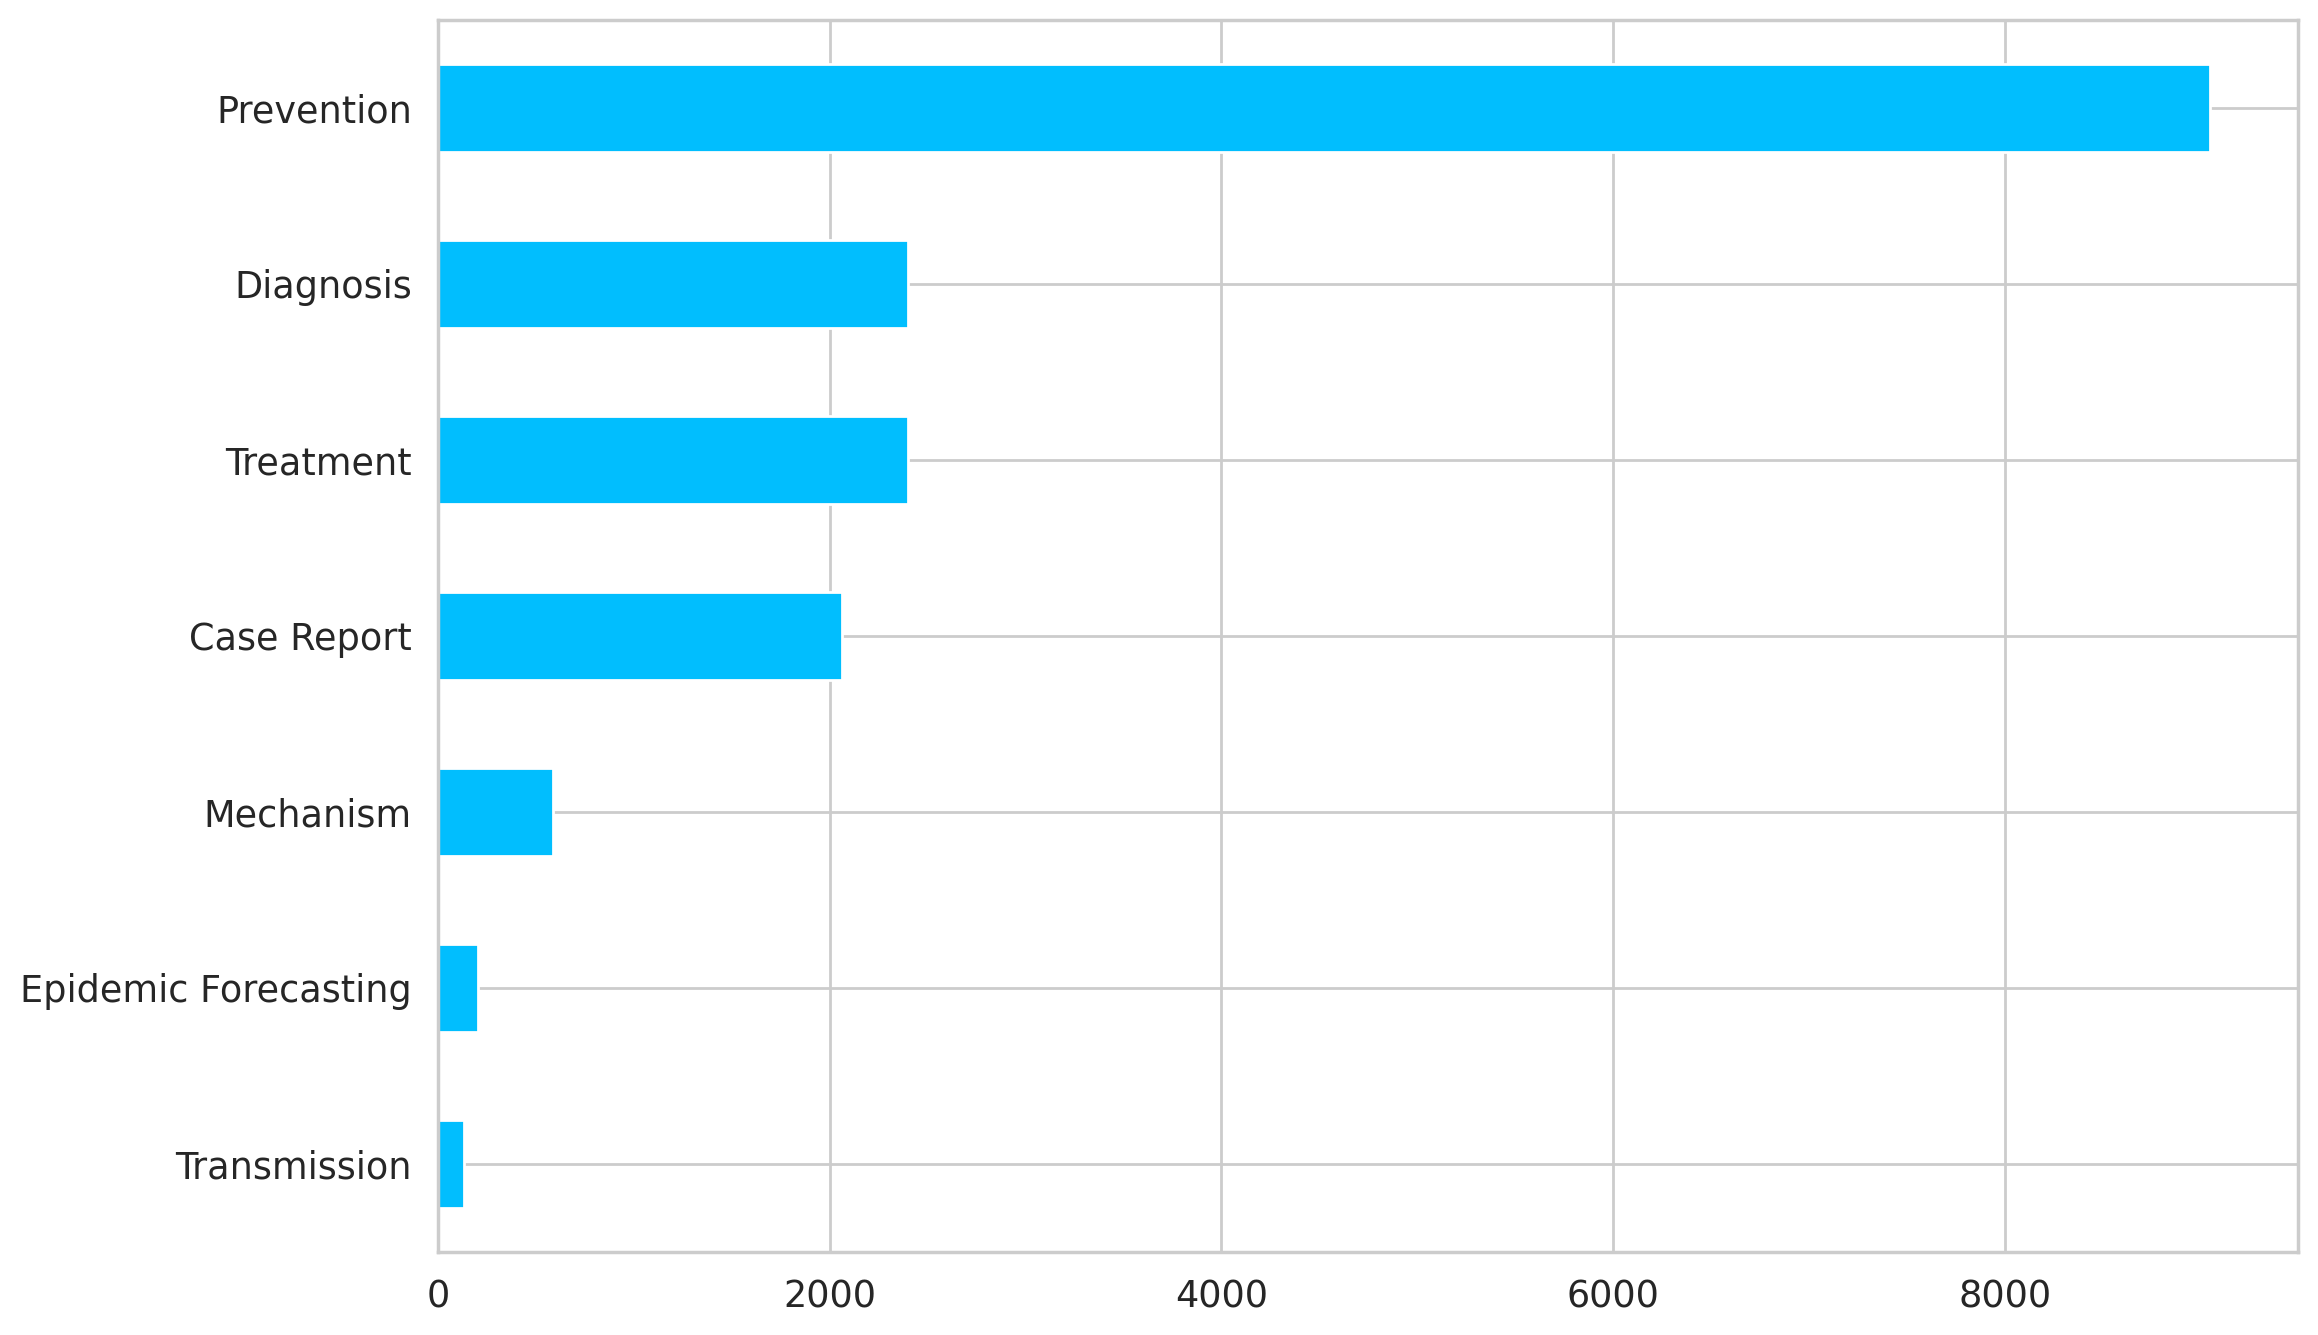

In [ ]:
# label distribution plot
train_df[labels].sum().sort_values().plot(kind="barh")

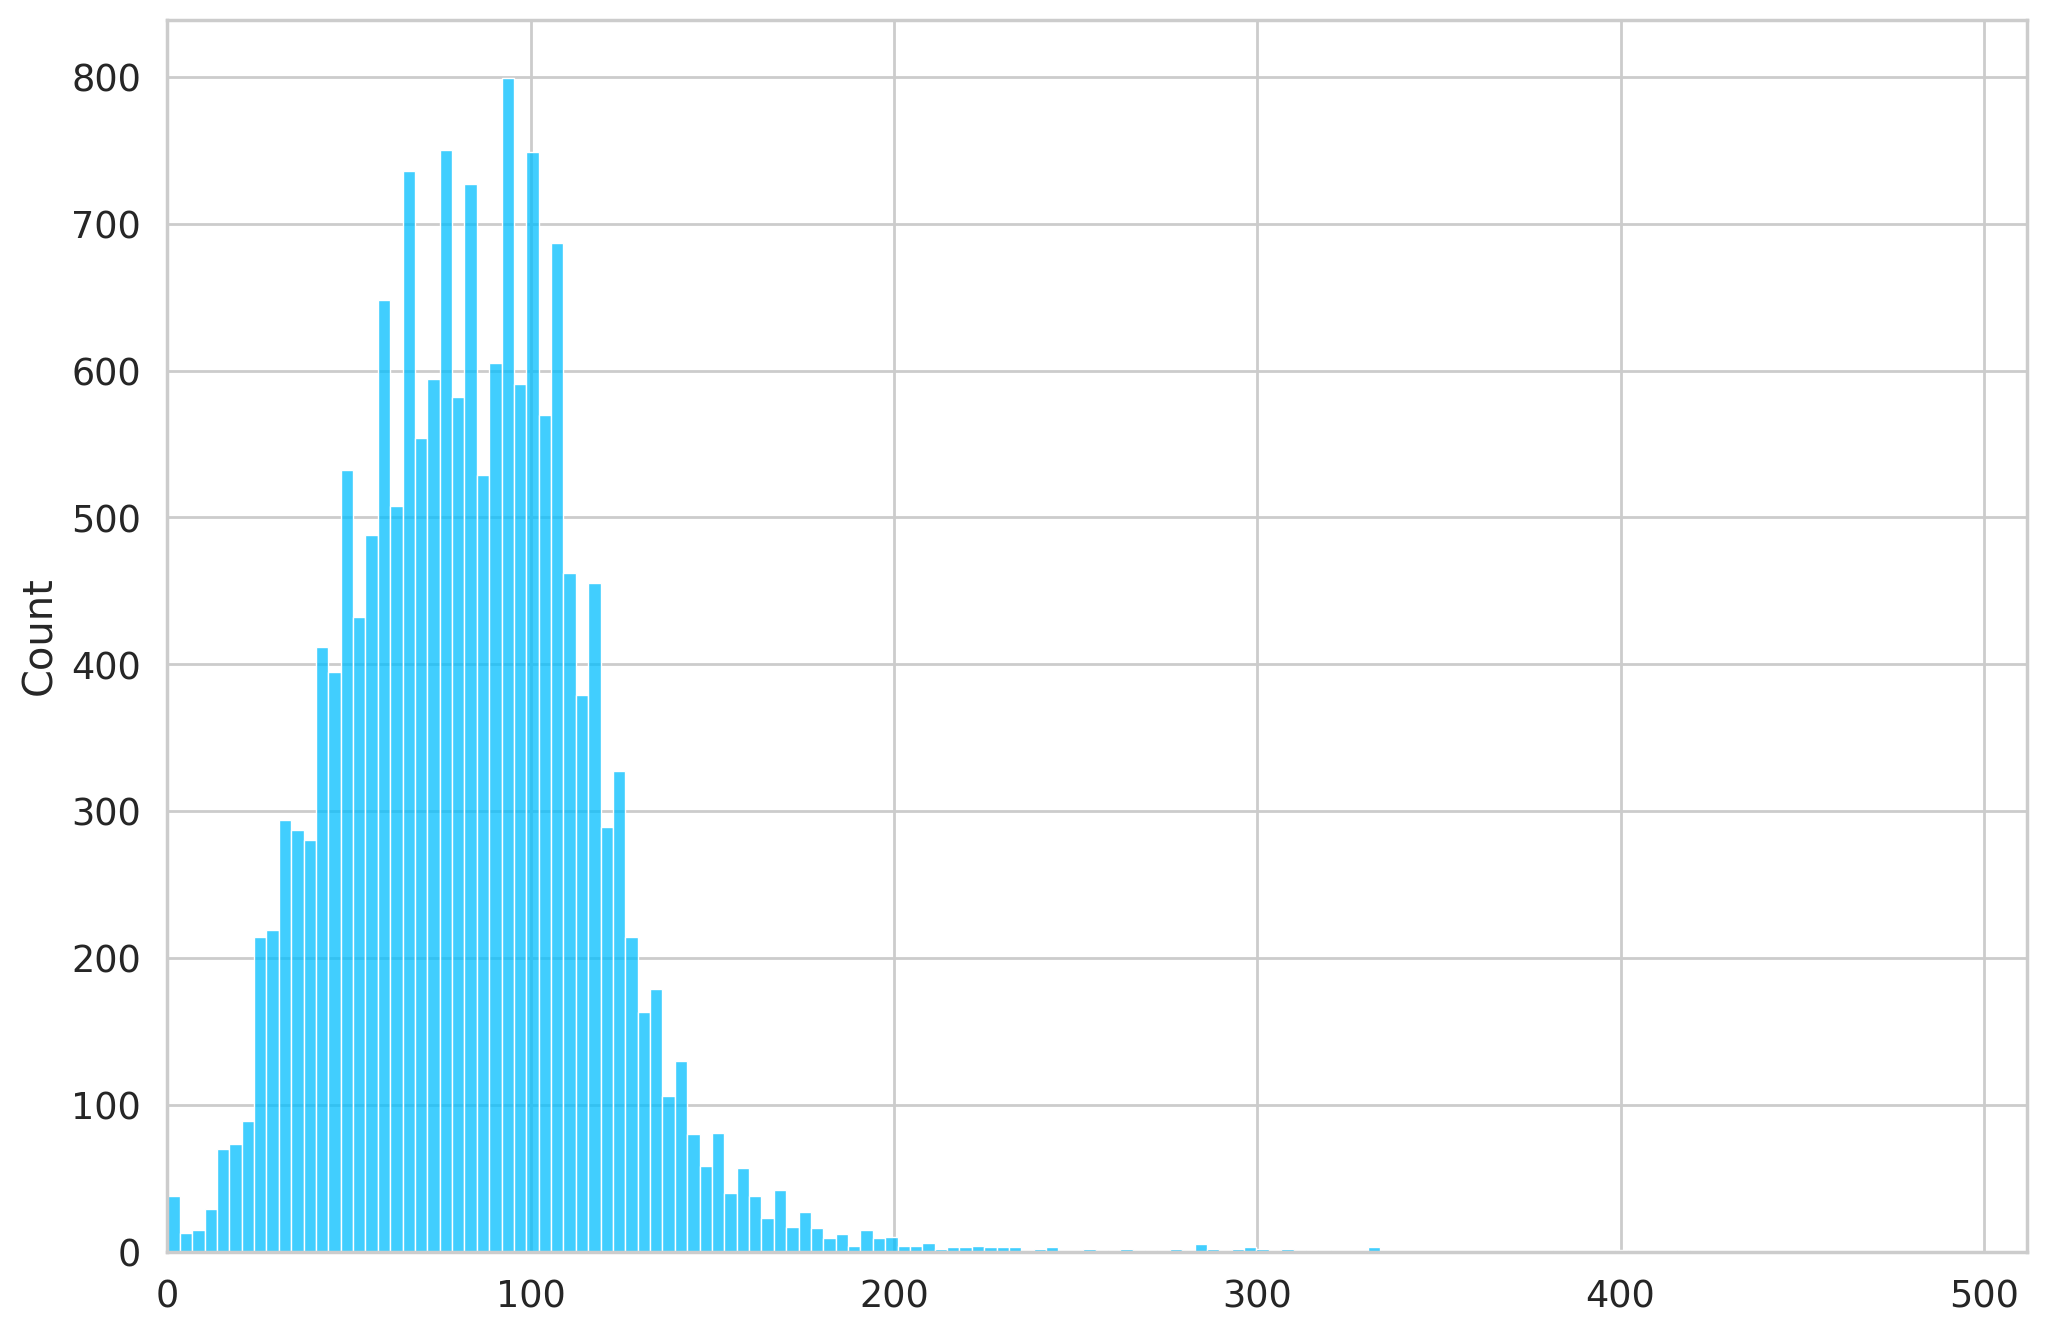

In [ ]:
# token counts plot
token_counts = np.count_nonzero(X_train.toarray(), axis=1).tolist()
sns.histplot(token_counts)
plt.xlim([0, 512]);